In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics import f1_score as f1

# Import the random forest package
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA

# __author__ = 'sabiryanovartur'

In [2]:
def visualize_data(total_data, train_size, test_size):
    ''' Visualization of total spam data
    :param total_data: Train and test data
    :param train_size: Size of train set
    :param test_size: Size of test set
    :return:
    '''
    pca = PCA(n_components=2)
    projection = pca.fit_transform(total_data)

    fig = pl.figure(figsize=(8, 8))

    pl.rcParams['legend.fontsize'] = 10
    pl.plot(projection[0:train_size, 0], projection[0:train_size, 1],
            'o', markersize=7, color='blue', alpha=0.5, label='Train')
    pl.plot(projection[train_size:train_size+test_size, 0], projection[train_size:train_size+test_size, 1],
            'o', markersize=7, color='red', alpha=0.5, label='Test')
    pl.title('Spam data')
    pl.show()


def classification_report(y_true, y_pred):
    ''' Computes clasification metrics

    :param y_true - original class label
    :param y_pred - predicted class label
    :return presicion, recall for each class; micro_f1 measure, macro_f1 measure
    '''
    last_line_heading = 'avg / total'
    final_line_heading = 'final score'

    labels = unique_labels(y_true, y_pred)

    width = len(last_line_heading)
    target_names = ['{0}'.format(l) for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 9s' for _ in headers])
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None)

    f1_macro = 0
    precision_macro = 0
    recall_macro = 0

    for i, label in enumerate(labels):
        values = [target_names[i]]
        f1_macro += f1[i]
        precision_macro += p[i]
        recall_macro += r[i]
        for v in (p[i], r[i], f1[i]):
            values += ["{0:0.5f}".format(v)]
        values += ["{0}".format(s[i])]
        report += fmt % tuple(values)

    report += '\n'

    # compute averages
    values = [last_line_heading]
    for v in (np.average(p, weights=s),
              np.average(r, weights=s),
              np.average(f1, weights=s)):
        values += ["{0:0.5f}".format(v)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    values = [final_line_heading]
    for v in (precision_macro, recall_macro, f1_macro):
        values += ["{0:0.5f}".format(v / labels.size)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    return report

In [3]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt('spam.test.txt')
total_data = np.concatenate(([train_data, test_data]), axis=0)

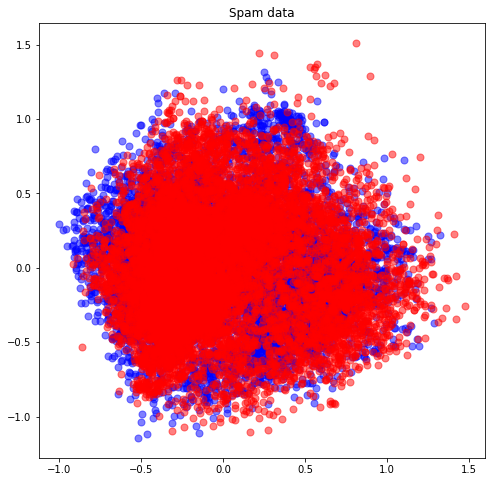

In [4]:
visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

# Пункт 2


In [8]:
# RandomForest
forest = RandomForestClassifier()
forest.fit(train_data[0::, 1::], train_data[0::, 0])
prediction = forest.predict(test_data[0::, 1::])
print(classification_report(test_data[0::, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.79059   0.95081   0.86333      2033
        1.0    0.98686   0.93618   0.96085      8023

avg / total    0.94718   0.93914   0.94114     10056
final score    0.88873   0.94350   0.91209     10056



In [9]:
# Support vector machine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_data[0::, 1::], train_data[0::, 0])
prediction = clf.predict(test_data[0::, 1::])
print(classification_report(test_data[0::, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.64016   0.97393   0.77253      2033
        1.0    0.99239   0.86127   0.92219      8023

avg / total    0.92118   0.88405   0.89194     10056
final score    0.81627   0.91760   0.84736     10056



In [10]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_data[0::, 1::], train_data[0::, 0])
prediction = clf.predict(test_data[0::, 1::])
print(classification_report(test_data[0::, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.78589   0.93704   0.85484      2033
        1.0    0.98323   0.93531   0.95867      8023

avg / total    0.94333   0.93566   0.93768     10056
final score    0.88456   0.93617   0.90675     10056



In [13]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, tol = 1e-2, max_iter=1000)
clf.fit(train_data[0::, 1::], train_data[0::, 0])
prediction = clf.predict(test_data[0::, 1::])
print(classification_report(test_data[0::, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.68527   0.95425   0.79770      2033
        1.0    0.98713   0.88894   0.93547      8023

avg / total    0.92610   0.90215   0.90761     10056
final score    0.83620   0.92160   0.86658     10056



Вывод: у RandomForestClassifier() результаты лучше чем у остальных алгоритмов классификации

# Пункт 3

In [10]:
max_trees = 200
results = np.zeros((7, 7))
number_of_features = len(train_data[0, :])


for i, features_percent in enumerate(np.linspace(0.3, 1, 7)):
    for j, trees_percent in enumerate(np.linspace(0.3, 1, 7)):
        use_features_in_tree = (int)(features_percent * number_of_features)
        trees = (int)(trees_percent * max_trees)
        forest = RandomForestClassifier(n_estimators = trees,
                                        max_features=use_features_in_tree-1)
        forest.fit(train_data[0::, 1::], train_data[0::, 0])
        prediction = forest.predict(test_data[0::, 1::])
        f1_sc = f1(test_data[0::, 0], prediction)
        results[i, j] = f1_sc

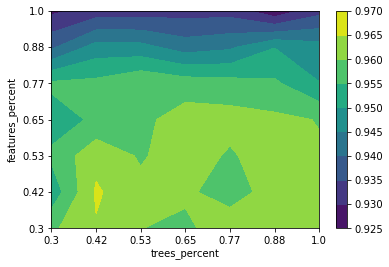

In [29]:
fig = pl.figure()
ax1 = fig.add_subplot(111)
cf = ax1.contourf(results) 
pl.colorbar(cf)
ax1.set_xticklabels([round(i, 2) for i in np.linspace(0.3, 1, 7)])
pl.ylabel('features_percent')
pl.xlabel('trees_percent')
ax1.set_yticklabels([round(i, 2) for i in np.linspace(0.3, 1, 7)])
pl.show()

# Пункт 4

Вопрос: Почему качество классификации для класса spam выше, чем для класса notspam?
Ответ: потому что для класса spam больше примеров